In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

pd.set_option('display.max_columns', None)


#### TO_DO:
#### 1) Estimate motorcycle VMT from fuel use and apply emission factors.


### Read and reformat Evolved service demand data for transportation sector for state chosen below

In [2]:
#Change these to run code for different states.
state = 'new mexico'
state_abbrev = 'NM'
today_date = 'feb5'

In [3]:
if state == 'nevada':
    state_fips = '32'
elif state == 'colorado':
    state_fips = '08'
elif state == 'new mexico':
    state_fips = '35'

In [4]:
d_service_demand = pd.read_csv('demand_outputs/d_service_demand.csv', low_memory=False)
d_service_demand = d_service_demand[(d_service_demand['WESTERN STATES'] == 'nevada') | (d_service_demand['WESTERN STATES'] == 'new mexico') | (d_service_demand['WESTERN STATES']=='colorado')]
transport_inds = d_service_demand['SECTOR']=='transportation'
transport_demand = d_service_demand[transport_inds]
state_inds = transport_demand['WESTERN STATES']==state
state_transport_demand = transport_demand[state_inds]

In [5]:
state_transport_demand

,TIMESTAMP,SCENARIO,SECTOR,WESTERN STATES,DEMAND_TECHNOLOGY,SUBSECTOR,YEAR,OTHER_INDEX_2,OTHER_INDEX_1,FINAL_ENERGY,UNIT,VALUE
1169940,2020-12-13 23:39:00,REFERENCE,transportation,new mexico,Battery Electric Medium-Duty Vehicle,medium duty trucks,2017,NaN,NaN,compressed pipeline gas,GIGAMILE,0.000000e+00
1169941,2020-12-13 23:39:00,REFERENCE,transportation,new mexico,Battery Electric Medium-Duty Vehicle,medium duty trucks,2017,NaN,NaN,diesel fuel,GIGAMILE,0.000000e+00
1169942,2020-12-13 23:39:00,REFERENCE,transportation,new mexico,Battery Electric Medium-Duty Vehicle,medium duty trucks,2017,NaN,NaN,electricity,GIGAMILE,0.000000e+00
1169943,2020-12-13 23:39:00,REFERENCE,transportation,new mexico,Battery Electric Medium-Duty Vehicle,medium duty trucks,2017,NaN,NaN,gasoline fuel,GIGAMILE,0.000000e+00
1169944,2020-12-13 23:39:00,REFERENCE,transportation,new mexico,Battery Electric Medium-Duty Vehicle,medium duty trucks,2017,NaN,NaN,liquid hydrogen,GIGAMILE,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
6189933,2020-12-13 23:39:00,LOW DEMAND,transportation,new mexico,Reference TDI Light-Duty Truck,light duty trucks,2050,NaN,light trucks,compressed pipeline gas,MILE,0.000000e+00
6189934,2020-12-13 23:39:00,LOW DEMAND,transportation,new mexico,Reference TDI Light-Duty Truck,light duty trucks,2050,NaN,light trucks,diesel fuel,MILE,8.826897e+06
6189935,2020-12-13 23:39:00,LOW DEMAND,transportation,new mexico,Reference TDI Light-Duty Truck,light duty trucks,2050,NaN,light trucks,electricity,MILE,0.000000e+00
6189936,2020-12-13 23:39:00,LOW DEMAND,transportation,new mexico,Reference TDI Light-Duty Truck,light duty trucks,2050,NaN,light trucks,gasoline fuel,MILE,0.000000e+00


In [6]:
states = d_service_demand['WESTERN STATES'].unique()
onroad_subsectors = ['medium duty trucks', 'light duty autos', 'light duty trucks',
       'transit buses', 'heavy duty trucks','school and intercity buses']

In [7]:
#Fill in 'DEMAND_TECHNOLOGY' with "school and intercity buses" for that subsector (to replace NaN values)

state_transport_demand = state_transport_demand[state_transport_demand['SUBSECTOR'].isin(onroad_subsectors)]
nan_inds = state_transport_demand['DEMAND_TECHNOLOGY'].isna()
bus_type = state_transport_demand[nan_inds]['OTHER_INDEX_1']
state_transport_demand.loc[nan_inds,'DEMAND_TECHNOLOGY'] = bus_type + ' buses'
state_transport_demand.loc[state_transport_demand['DEMAND_TECHNOLOGY']=='school buses', 'SUBSECTOR'] = state_transport_demand['DEMAND_TECHNOLOGY']
state_transport_demand.loc[state_transport_demand['DEMAND_TECHNOLOGY']=='intercity buses', 'SUBSECTOR'] = state_transport_demand['DEMAND_TECHNOLOGY']
state_transport_demand.loc[state_transport_demand['FINAL_ENERGY'].isna(), 'FINAL_ENERGY'] = 'bus_fuelmix'

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [8]:
#state_transport_demandnvert rows with miles units to gigamiles.
mile_inds = state_transport_demand['UNIT']=='MILE'
state_transport_demand.loc[mile_inds,'VALUE']= state_transport_demand.loc[mile_inds,'VALUE']/ 1000000000
state_transport_demand.loc[mile_inds,'UNIT']= 'GIGAMILE'

#### Drop vehicle type <> fuel type pairs that are zero values throughout all year-scenarios.

In [9]:
invalid_fuel_groups = state_transport_demand.groupby(['DEMAND_TECHNOLOGY', 'FINAL_ENERGY'])['VALUE'].sum() == 0
invalid_fuel_inds = []
for i in range(state_transport_demand.shape[0]):
    row = state_transport_demand.iloc[i]
    dt = row['DEMAND_TECHNOLOGY']
    fe = row['FINAL_ENERGY']
    drop = invalid_fuel_groups[dt,fe]
    invalid_fuel_inds.append(drop)
invalid_fuel_inds = np.array(invalid_fuel_inds)
state_transport_demand = state_transport_demand[~invalid_fuel_inds]

### Read and reformat Evolved d_energy ouput for transportation sector

In [10]:
d_energy = pd.read_csv('demand_outputs/d_energy.csv', low_memory=False)
d_energy = d_energy[(d_energy['WESTERN STATES'] == 'nevada') | (d_energy['WESTERN STATES'] == 'new mexico') | (d_energy['WESTERN STATES']=='colorado')]
transport_inds = d_energy['SECTOR']=='transportation'
transport_energy = d_energy[transport_inds]
state_inds = transport_energy['WESTERN STATES']==state
state_transport_energy = transport_energy[state_inds]

In [11]:
#Fill in 'DEMAND_TECHNOLOGY' with specific bus type (school or intercity) for that subsector (to replace NaN values)

state_transport_energy = state_transport_energy[state_transport_energy['SUBSECTOR'].isin(onroad_subsectors)]
nan_inds = state_transport_energy['DEMAND_TECHNOLOGY'].isna()
bus_type = state_transport_energy[nan_inds]['OTHER_INDEX_1']
state_transport_energy.loc[nan_inds,'DEMAND_TECHNOLOGY'] = bus_type + ' buses'
state_transport_energy.loc[state_transport_energy['DEMAND_TECHNOLOGY']=='school buses', 'SUBSECTOR'] = state_transport_energy['DEMAND_TECHNOLOGY']
state_transport_energy.loc[state_transport_energy['DEMAND_TECHNOLOGY']=='intercity buses', 'SUBSECTOR'] = state_transport_energy['DEMAND_TECHNOLOGY']

##### Drop vehicle type <> fuel type pairs that are zero values throughout all year-scenarios.

In [12]:
invalid_fuel_groups = state_transport_energy.groupby(['DEMAND_TECHNOLOGY', 'FINAL_ENERGY'])['VALUE'].sum() == 0
invalid_fuel_inds = []
for i in range(state_transport_energy.shape[0]):
    row = state_transport_energy.iloc[i]
    dt = row['DEMAND_TECHNOLOGY']
    fe = row['FINAL_ENERGY']
    drop = invalid_fuel_groups[dt,fe]
    invalid_fuel_inds.append(drop)
invalid_fuel_inds = np.array(invalid_fuel_inds)
state_transport_energy = state_transport_energy[~invalid_fuel_inds]

##### Derive school and intercity bus VMT from fuel use

In [13]:
intercitybus_inds = state_transport_energy['DEMAND_TECHNOLOGY']=='intercity buses'
schoolbus_inds = state_transport_energy['DEMAND_TECHNOLOGY']=='school buses'
bus_vmt = state_transport_energy[intercitybus_inds | schoolbus_inds]

In [14]:
#Converts mmbtu to diesel gallon equivalents.
bus_vmt['GALLONS (DGE)'] = bus_vmt['VALUE']/0.137381

#Uses Argonne AFLEET tool fuel economy (MPDGE) data for school buses. Assumes fuel economies are the same for school and intercity buses.
fuel_economy = {
    'diesel fuel': 7.7,
    'gasoline fuel': 6.4,
    'electricity': 19.6,
    'compressed pipeline gas': 6.5,
    'lpg fuel': 6.4,
}

<ipython-input-14-a553bb75cf81>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_vmt['GALLONS (DGE)'] = bus_vmt['VALUE']/0.137381


In [15]:
for fuel in bus_vmt['FINAL_ENERGY'].unique():
    fuel_inds = bus_vmt['FINAL_ENERGY']==fuel
    mpdge = fuel_economy[fuel]
    bus_vmt.loc[fuel_inds,'fuelVMT'] = bus_vmt['GALLONS (DGE)']*mpdge

#Calculate fraction of total VMT for each fuel type. Assumes ratio of fuel economies for different fuel types stays constant from 2020-2050.
bus_vmt['totalVMT'] = bus_vmt['fuelVMT'].groupby([bus_vmt['SCENARIO'],bus_vmt['DEMAND_TECHNOLOGY'],bus_vmt['YEAR']]).transform('sum')
bus_vmt['fraction_totalVMT'] = bus_vmt['fuelVMT']/ bus_vmt['totalVMT']

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-15-8a122e53ded4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [16]:
bus_transport_demand = state_transport_demand[state_transport_demand['FINAL_ENERGY']=='bus_fuelmix']
for scenario in bus_vmt['SCENARIO'].unique():
    vmt_scenario_inds = bus_transport_demand['SCENARIO']==scenario 
    energy_scenario_inds = bus_vmt['SCENARIO']==scenario 
    for bustype in bus_vmt['DEMAND_TECHNOLOGY'].unique():
        vmt_bustype_inds = bus_transport_demand['DEMAND_TECHNOLOGY']==bustype 
        energy_bustype_inds = bus_vmt['DEMAND_TECHNOLOGY']==bustype
        for year in bus_vmt['YEAR'].unique():
            vmt_year_inds = bus_transport_demand['YEAR']==year
            energy_year_inds = bus_vmt['YEAR']==year
            
            vmt_allinds = vmt_scenario_inds & vmt_bustype_inds & vmt_year_inds
            gigamile = bus_transport_demand[vmt_allinds]['VALUE'].item()
            
            energy_allinds = energy_scenario_inds & energy_bustype_inds & energy_year_inds
            bus_vmt.loc[energy_allinds,'GIGAMILE'] = gigamile

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [17]:
bus_vmt['fuelGIGAMILE'] = bus_vmt['fraction_totalVMT'] * bus_vmt['GIGAMILE']
bus_vmt.drop(columns=['VALUE','GALLONS (DGE)','fuelVMT','totalVMT','fraction_totalVMT','GIGAMILE'],inplace=True)
bus_vmt['UNIT'] = 'GIGAMILE'
bus_vmt.rename(columns={'fuelGIGAMILE': 'VALUE'}, inplace=True)
bus_vmt['DEMAND_TECHNOLOGY'] = bus_vmt['SUBSECTOR']+ '_' + bus_vmt['FINAL_ENERGY']

<ipython-input-17-33278c5aa832>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_vmt['fuelGIGAMILE'] = bus_vmt['fraction_totalVMT'] * bus_vmt['GIGAMILE']
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-17-33278c5aa832>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [18]:
#Drop generic bus rows from service_demand dataset and replace with derived bus vmt values by fuel type.
bus_inds = state_transport_demand['FINAL_ENERGY'] =='bus_fuelmix'
state_transport_demand = state_transport_demand[~bus_inds]
state_transport_demand = pd.concat([state_transport_demand, bus_vmt],ignore_index=True)

In [19]:
#state_transport_demand.to_csv('my outputs/{}_service_demand_with_busvmt.csv'.format(state_abbrev))

### Plot fuel use by vehicle subsector for each decarb scenario

In [20]:
all_fes = state_transport_energy.FINAL_ENERGY.unique()
color_list = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ordered_colors = color_list[[2,1,0,3,4,5,6]]
fuel_colors = {all_fes[i]: ordered_colors[i] for i in range(len(all_fes))}

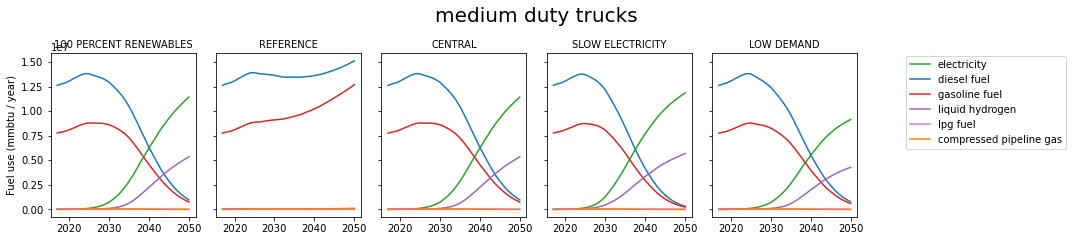

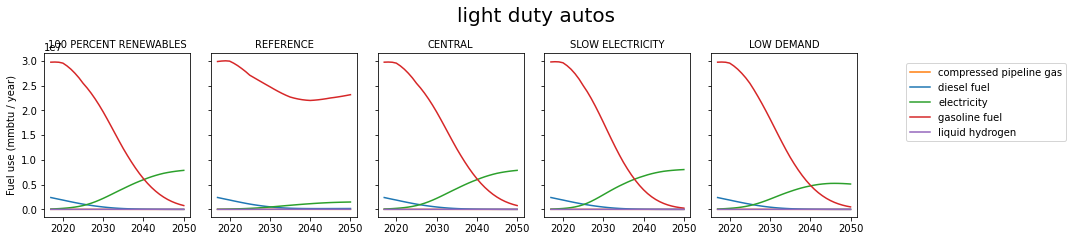

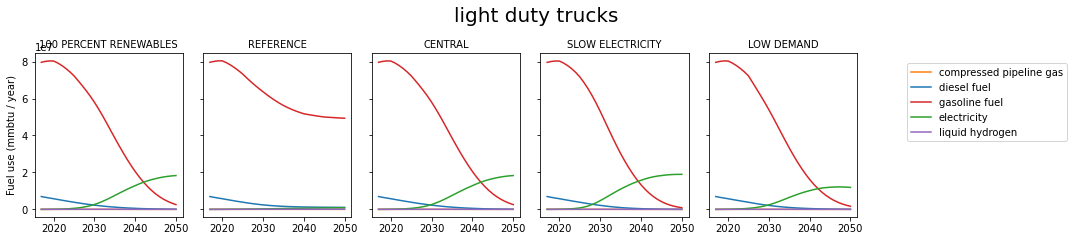

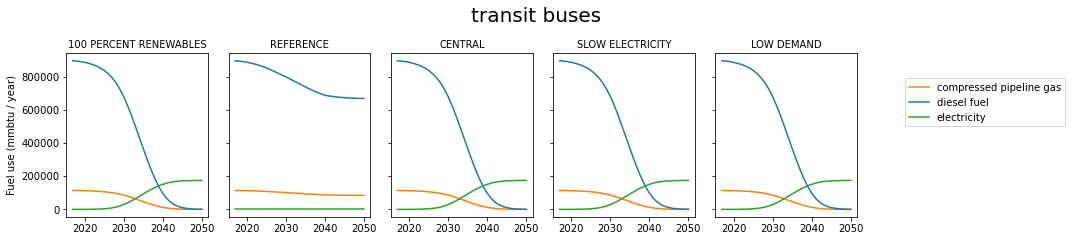

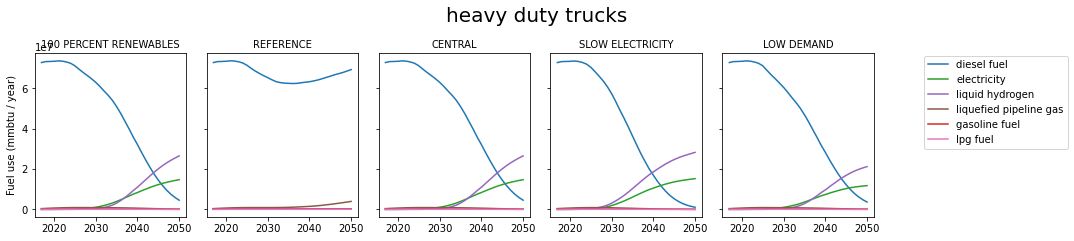

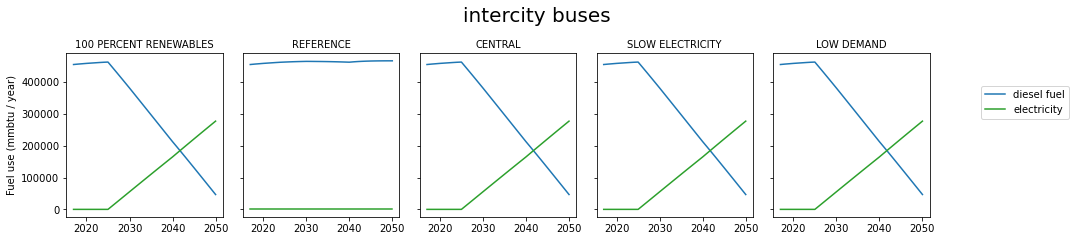

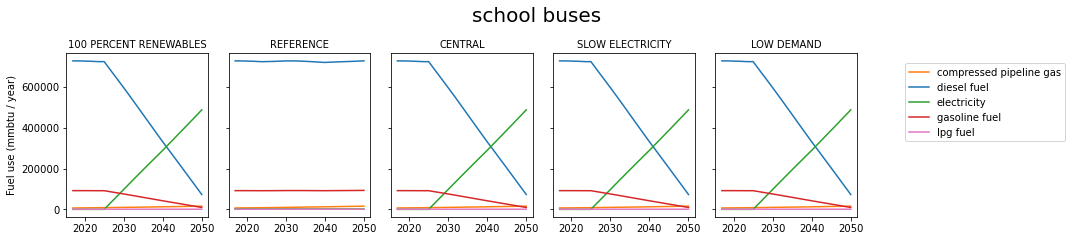

In [21]:
subsectors = state_transport_energy.SUBSECTOR.unique()
scenarios = state_transport_energy.SCENARIO.unique()
scenarios = scenarios[[2,0,1,3,4]] #reorder

for subsector in subsectors:
    subsector_inds = state_transport_energy.SUBSECTOR == subsector
    fig, ax_array = plt.subplots(1, len(scenarios), sharey=True, figsize=(15,3))
    fig.suptitle(subsector, fontsize=20, y=1.1)
    np.ravel(ax_array)[0].set_ylabel('Fuel use (mmbtu / year)')
    for i, scenario in enumerate(scenarios):
        scenario_inds = state_transport_energy.SCENARIO == scenario
        inds = subsector_inds & scenario_inds
        sub_df = state_transport_energy[inds]
        final_energys = sub_df.FINAL_ENERGY.unique()
        np.ravel(ax_array)[i].set_title(scenario, fontsize=10)
        for fe in final_energys:
            fe_inds = sub_df.FINAL_ENERGY == fe 
            values = sub_df[fe_inds].groupby('YEAR')['VALUE'].sum()

            np.ravel(ax_array)[i].plot(values, label=fe, c=fuel_colors[fe])

    np.ravel(ax_array)[i].legend()
    np.ravel(ax_array)[i].legend(loc='center left', bbox_to_anchor=(1.3,.7))
    
    plt.tight_layout()
    #plt.savefig('my figures/transportation/fuel use/{}_byscenario.png'.format(state_abbrev + '_fueluse_' + subsector),bbox_inches='tight',dpi=400)        


### Plot changes in VMT (service demand) by vehicle subsector for each decarb scenario

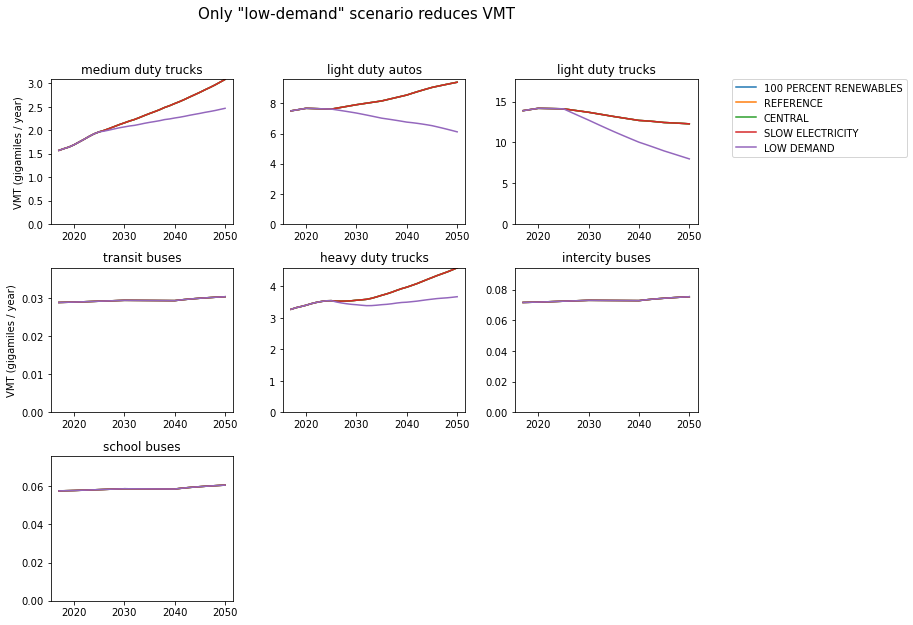

In [22]:
subsectors = state_transport_demand.SUBSECTOR.unique()
scenarios = state_transport_demand.SCENARIO.unique()
scenarios = scenarios[[2,0,1,3,4]] #reorder

fig, ax_array = plt.subplots(3, len(subsectors)//2, figsize=(10,8))
fig.suptitle('Only "low-demand" scenario reduces VMT',y=1.08, fontsize=15)

for i, subsector in enumerate(subsectors):
    subsector_inds = state_transport_demand.SUBSECTOR == subsector
    np.ravel(ax_array)[i].set_title(subsector, y=1)
    np.ravel(ax_array)[0].set_ylabel('VMT (gigamiles / year)')
    np.ravel(ax_array)[3].set_ylabel('VMT (gigamiles / year)')
    for scenario in scenarios:
        scenario_inds = state_transport_demand.SCENARIO == scenario
        inds = subsector_inds & scenario_inds
        sub_df = state_transport_demand[inds]
        values = sub_df.groupby('YEAR')['VALUE'].sum()
        np.ravel(ax_array)[i].plot(values, label=scenario)
        np.ravel(ax_array)[i].set_ylim(ymin=0, ymax=values.max()+(values.max()/4))
np.ravel(ax_array)[i].legend()
plt.tight_layout()
np.ravel(ax_array)[i].legend(loc='center left', bbox_to_anchor=(3.7,3.34))
fig.delaxes(ax_array[2][1])
fig.delaxes(ax_array[2][2])

#plt.savefig('my figures/transportation/vmt/{}_totalVMT_bysubsector.png'.format(state_abbrev),bbox_inches='tight',dpi=80) 

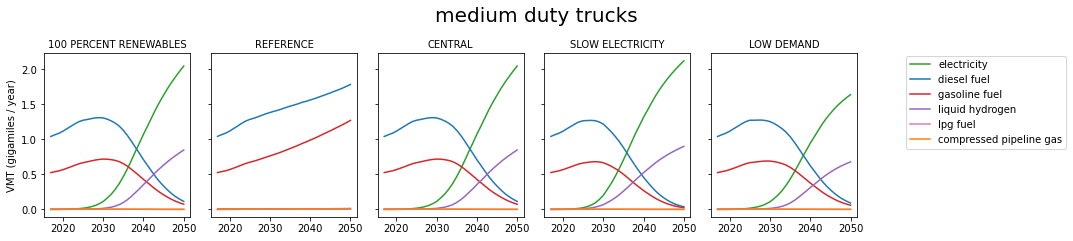

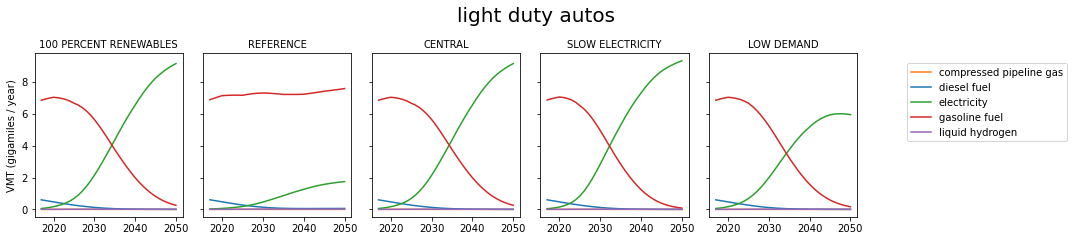

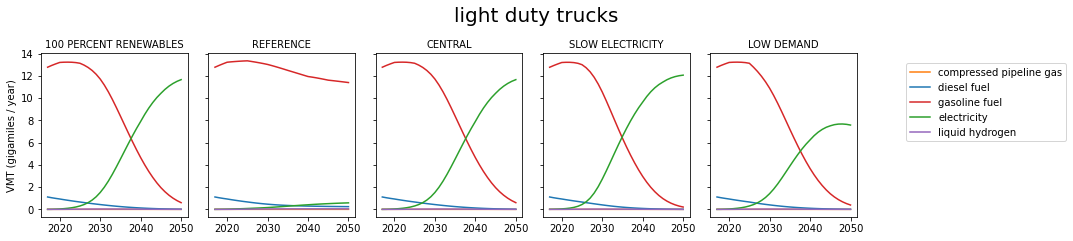

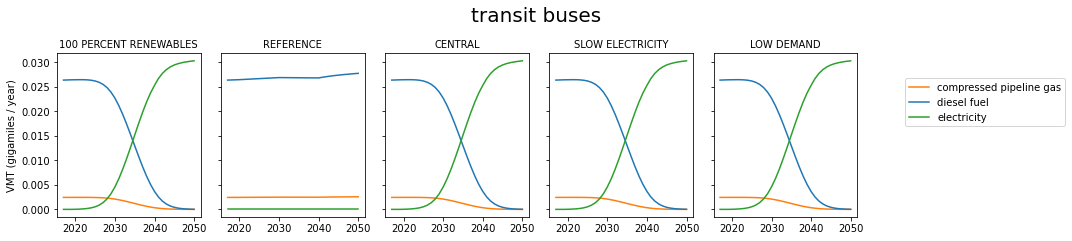

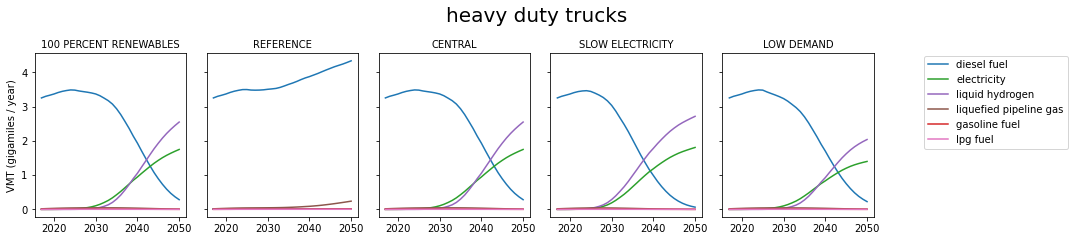

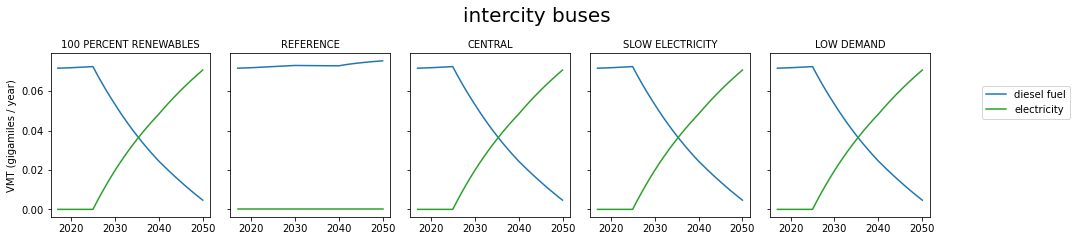

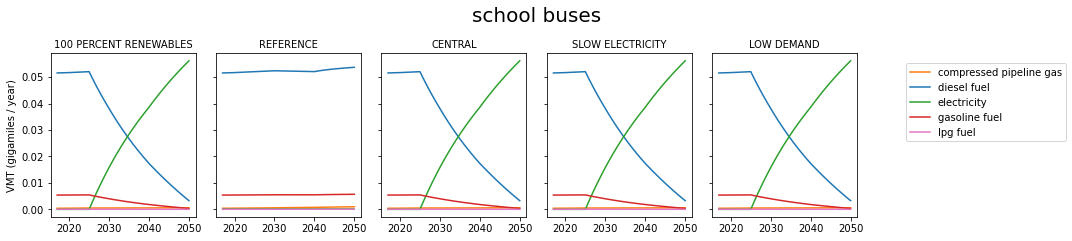

In [23]:
for subsector in subsectors:
    subsector_inds = state_transport_demand.SUBSECTOR == subsector
    fig, ax_array = plt.subplots(1, len(scenarios), sharey=True, figsize=(15,3))
    fig.suptitle(subsector, fontsize=20, y=1.1)
    np.ravel(ax_array)[0].set_ylabel('VMT (gigamiles / year)')
    for i, scenario in enumerate(scenarios):
        scenario_inds = state_transport_demand.SCENARIO == scenario
        inds = subsector_inds & scenario_inds
        sub_df = state_transport_demand[inds]
        final_energys = sub_df.FINAL_ENERGY.unique()
        np.ravel(ax_array)[i].set_title(scenario, fontsize=10)
        for fe in final_energys:
            fe_inds = sub_df.FINAL_ENERGY == fe 
            values = sub_df[fe_inds].groupby('YEAR')['VALUE'].sum()

            np.ravel(ax_array)[i].plot(values, label=fe, c=fuel_colors[fe])

    np.ravel(ax_array)[i].legend()
    np.ravel(ax_array)[i].legend(loc='center left', bbox_to_anchor=(1.3,.7))
    
    plt.tight_layout()
    #plt.savefig('my figures/transportation/vmt/{}_byfueltype.png'.format(state_abbrev + '_vmt_' + subsector),bbox_inches='tight',dpi=400)        


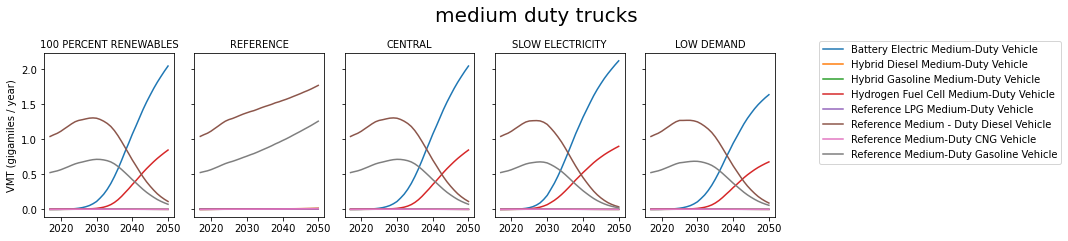

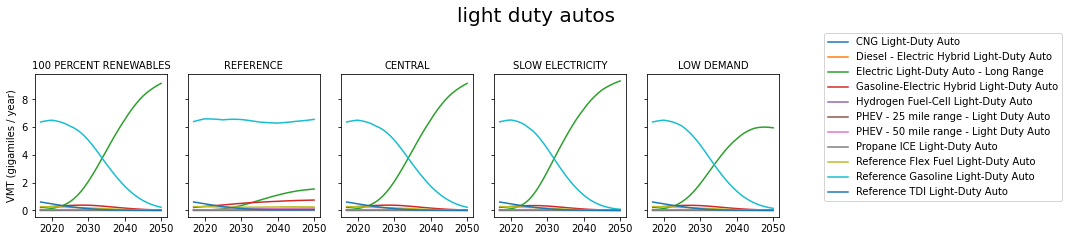

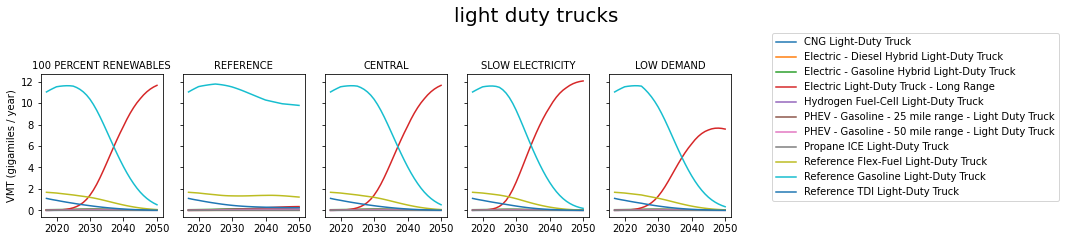

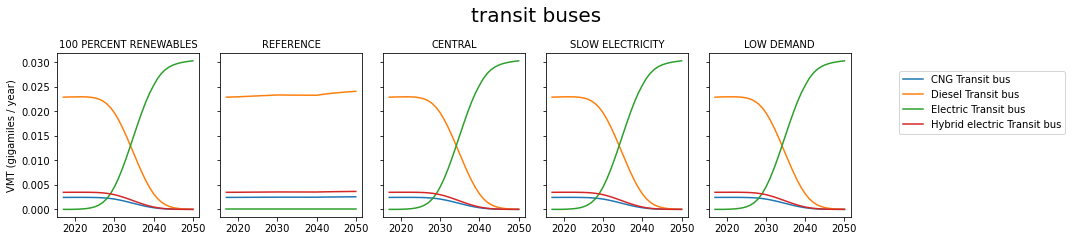

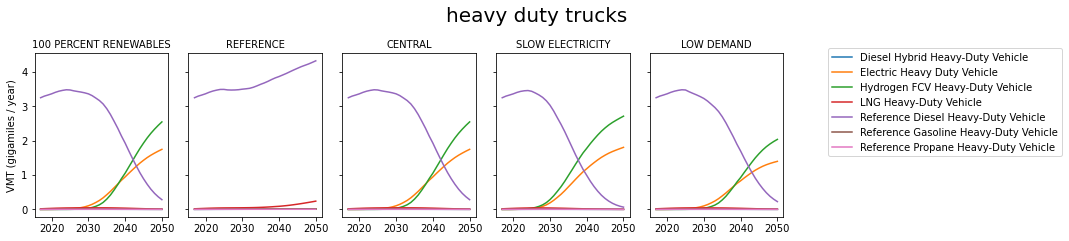

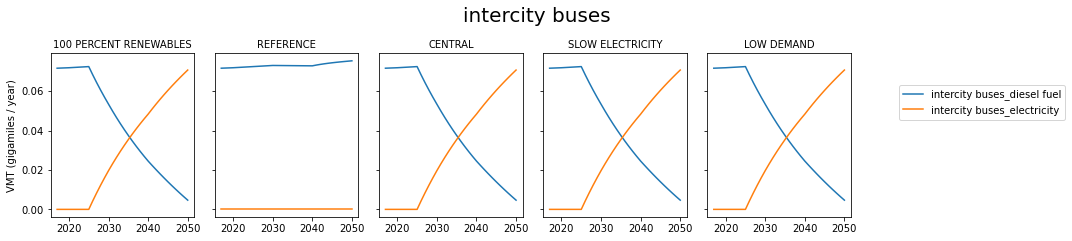

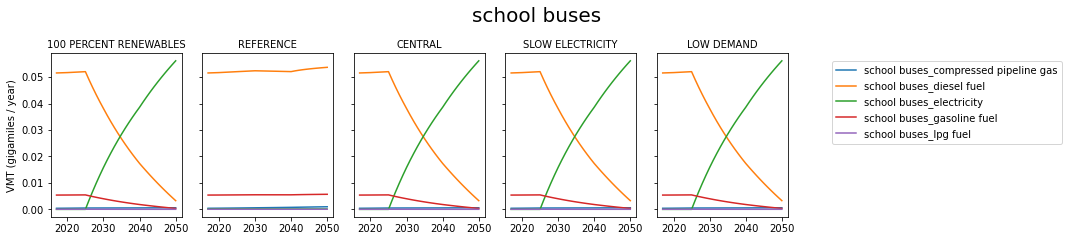

In [24]:
for subsector in state_transport_demand.SUBSECTOR.unique():
    subsector_inds = state_transport_demand.SUBSECTOR == subsector
    fig, ax_array = plt.subplots(1, len(scenarios), sharey=True, figsize=(15,3))
    fig.suptitle(subsector, fontsize=20, y=1.1)
    np.ravel(ax_array)[0].set_ylabel('VMT (gigamiles / year)')
    for i, scenario in enumerate(scenarios):
        scenario_inds = state_transport_demand.SCENARIO == scenario
        inds = subsector_inds & scenario_inds
        sub_df = state_transport_demand[inds]
        demand_techs = sub_df.DEMAND_TECHNOLOGY.unique()
        np.ravel(ax_array)[i].set_title(scenario, fontsize=10)
        for dt in demand_techs:
            dt_inds = sub_df.DEMAND_TECHNOLOGY == dt 
            values = sub_df[dt_inds].groupby('YEAR')['VALUE'].sum()

            np.ravel(ax_array)[i].plot(values, label=dt)

    np.ravel(ax_array)[i].legend()
    np.ravel(ax_array)[i].legend(loc='center left', bbox_to_anchor=(1.3,.7))
    
    plt.tight_layout()
    #plt.savefig('my figures/transportation/vmt/{}_vmt_bydemandtechnology.png'.format(state_abbrev + '_vmt_' + subsector),bbox_inches='tight',dpi=400)        


# Analyze emissions

In [25]:
#Missing emission factors for HEVs that use fuel other than default fuel in AFLEET tool (ex. diesel-HEV light-duty auto). This is not consequential, since VMT from these types of hybrids are minimal in the Evolved model.

mapping_fuels = {
    'Battery Electric Medium-Duty Vehicle': 'EV', 
    'CNG Light-Duty Auto': 'CNG',
    'CNG Light-Duty Truck': 'CNG',
    'CNG Transit bus': 'CNG',
    'Diesel - Electric Hybrid Light-Duty Auto': 'HEV', #Need emission factor
    'Diesel Hybrid Heavy-Duty Vehicle': 'HEV',
    'Diesel Transit bus': 'diesel',
    'Electric - Diesel Hybrid Light-Duty Truck': 'HEV', #Need emission factor
    'Electric - Gasoline Hybrid Light-Duty Truck': 'HEV',
    'Electric Heavy Duty Vehicle': 'EV',
    'Electric Light-Duty Auto - 200 mile range': 'EV',
    'Electric Light-Duty Auto - Long Range' : 'EV',
    'Electric Light-Duty Truck - 200 mile range': 'EV',
    'Electric Light-Duty Truck - Long Range': 'EV', 
    'Electric Transit bus': 'EV',
    'Gasoline-Electric Hybrid Light-Duty Auto': 'HEV',
    'Hybrid Diesel Medium-Duty Vehicle': 'HEV',
    'Hybrid Gasoline Medium-Duty Vehicle': 'HEV', #Need emission factor
    'Hybrid electric Transit bus': 'HEV', 
    'Hydrogen FCV Heavy-Duty Vehicle': 'FCV',
    'Hydrogen Fuel Cell Medium-Duty Vehicle': 'FCV',
    'Hydrogen Fuel-Cell Light-Duty Auto': 'FCV',
    'Hydrogen Fuel-Cell Light-Duty Truck': 'FCV', 
    'LNG Heavy-Duty Vehicle': 'LNG',
    'PHEV - 25 mile range - Light Duty Auto': 'PHEV',
    'PHEV - 50 mile range - Light Duty Auto': 'PHEV',
    'PHEV - Gasoline - 25 mile range - Light Duty Truck': 'PHEV',
    'PHEV - Gasoline - 50 mile range - Light Duty Truck': 'PHEV',
    'Propane ICE Light-Duty Auto': 'LPG', 
    'Propane ICE Light-Duty Truck': 'LPG',
    'Reference Diesel Heavy-Duty Vehicle': 'diesel',
    'Reference Flex Fuel Light-Duty Auto': 'E85',
    'Reference Flex-Fuel Light-Duty Truck': 'E85',
    'Reference Gasoline Heavy-Duty Vehicle': 'gasoline',
    'Reference Gasoline Light-Duty Auto': 'gasoline',
    'Reference Gasoline Light-Duty Truck': 'gasoline',
    'Reference LPG Medium-Duty Vehicle': 'LPG',
    'Reference Medium - Duty Diesel Vehicle': 'diesel',
    'Reference Medium-Duty CNG Vehicle': 'CNG',
    'Reference Medium-Duty Gasoline Vehicle': 'gasoline',
    'Reference Propane Heavy-Duty Vehicle': 'LPG',
    'Reference TDI Light-Duty Auto': 'diesel', 
    'Reference TDI Light-Duty Truck': 'diesel',
    'school buses_compressed pipeline gas': 'CNG',
    'school buses_diesel fuel': 'diesel',
    'school buses_electricity': 'EV',
    'school buses_gasoline fuel': 'gasoline',
    'school buses_lpg fuel': 'LPG',
    'intercity buses_diesel fuel': 'diesel',
    'intercity buses_electricity': 'EV'}

In [26]:
for vehicle in state_transport_demand['DEMAND_TECHNOLOGY'].unique():
    vehicle_inds = state_transport_demand['DEMAND_TECHNOLOGY']==vehicle
    fuel = mapping_fuels[vehicle]
    state_transport_demand.loc[vehicle_inds,'Fuel Type'] = fuel

In [27]:
efs = pd.read_csv('my outputs/{}_allvehicle_efs.csv'.format(state_abbrev.lower()))
efs.drop(columns='Unnamed: 0', inplace=True)

In [28]:
pols = list(efs['Pollutant'].unique())
r = np.arange(len(state_transport_demand)).repeat(len(pols))
pols_col = pols*len(state_transport_demand)
new = pd.DataFrame(state_transport_demand.values[r], state_transport_demand.index[r], state_transport_demand.columns)
new['pollutant'] = pols_col

In [29]:
new['emissions (metric tons)'] = 0

In [30]:
efs

,evolved_category,Pollutant,Reference/AFV,Fuel Type,emissions (g/mile)
0,heavy duty trucks,CO,AFV,B100,3.614833
1,heavy duty trucks,CO,AFV,B20,3.614833
2,heavy duty trucks,CO,AFV,CNG,56.703233
3,heavy duty trucks,CO,AFV,Diesel,3.614833
4,heavy duty trucks,CO,AFV,E85,0.000000
...,...,...,...,...,...
1035,transit buses,VOC (Evap),AFV,PHEV,0.043336
1036,transit buses,VOC (Evap),AFV,RD100,0.043336
1037,transit buses,VOC (Evap),AFV,RD20,0.043336
1038,transit buses,VOC (Evap),Reference,CNG,NaN


### TO-DO: could re-do this to apply emission factors just to gasoline or diesel miles for HEV, PHEV (vs. apply AFLEET afv emission factors to all miles driven by HEV or PHEV).

#### This would allow for reformatting the data by final energy use (rather than by EV, PHEV, etc).

In [31]:
for vehicle in new['SUBSECTOR'].unique():
    new_vehicle_inds = new['SUBSECTOR'] == vehicle
    if vehicle in ['intercity buses','school buses']:
        efs_vehicle_inds = efs['evolved_category'] == 'school and intercity buses'
    else:
        efs_vehicle_inds = efs['evolved_category'] == vehicle
    for fuel in new['Fuel Type'].unique():
        new_fuel_inds = new['Fuel Type'] == fuel
        efs_fuel_inds = efs['Fuel Type'] == fuel
        for pol in new['pollutant'].unique():
            new_pol_inds = new['pollutant'] == pol
            efs_pol_inds = efs['Pollutant'] == pol
            
            new_all_inds = new_vehicle_inds & new_fuel_inds & new_pol_inds
            efs_all_inds = efs_vehicle_inds & efs_fuel_inds & efs_pol_inds
            
            miles = new[new_all_inds]['VALUE'] * 1000000000
            
            #TODO miles : np.array(scenario, year)
            # TODO efs np.array(year)
            
            ef = efs.loc[efs_all_inds,'emissions (g/mile)']
            
            if ef.empty:
                new.loc[new_all_inds,'emissions (metric tons)'] = 0
            else:
                ef = ef.item()
                grams = miles * ef
                new.loc[new_all_inds,'emissions (metric tons)'] = grams / 1000000

In [32]:
new

,TIMESTAMP,SCENARIO,SECTOR,WESTERN STATES,DEMAND_TECHNOLOGY,SUBSECTOR,YEAR,OTHER_INDEX_2,OTHER_INDEX_1,FINAL_ENERGY,UNIT,VALUE,Fuel Type,pollutant,emissions (metric tons)
0,2020-12-13 23:39:00,REFERENCE,transportation,new mexico,Battery Electric Medium-Duty Vehicle,medium duty trucks,2017,NaN,NaN,electricity,GIGAMILE,0,EV,CO,0
0,2020-12-13 23:39:00,REFERENCE,transportation,new mexico,Battery Electric Medium-Duty Vehicle,medium duty trucks,2017,NaN,NaN,electricity,GIGAMILE,0,EV,NOx,0
0,2020-12-13 23:39:00,REFERENCE,transportation,new mexico,Battery Electric Medium-Duty Vehicle,medium duty trucks,2017,NaN,NaN,electricity,GIGAMILE,0,EV,PM10,0
0,2020-12-13 23:39:00,REFERENCE,transportation,new mexico,Battery Electric Medium-Duty Vehicle,medium duty trucks,2017,NaN,NaN,electricity,GIGAMILE,0,EV,PM10 (TBW),0
0,2020-12-13 23:39:00,REFERENCE,transportation,new mexico,Battery Electric Medium-Duty Vehicle,medium duty trucks,2017,NaN,NaN,electricity,GIGAMILE,0,EV,PM2.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12239,2020-12-13 23:39:00,LOW DEMAND,transportation,new mexico,school buses_lpg fuel,school buses,2050,NaN,school,lpg fuel,GIGAMILE,2.69663e-05,LPG,PM10 (TBW),0.0025618
12239,2020-12-13 23:39:00,LOW DEMAND,transportation,new mexico,school buses_lpg fuel,school buses,2050,NaN,school,lpg fuel,GIGAMILE,2.69663e-05,LPG,PM2.5,0.00677701
12239,2020-12-13 23:39:00,LOW DEMAND,transportation,new mexico,school buses_lpg fuel,school buses,2050,NaN,school,lpg fuel,GIGAMILE,2.69663e-05,LPG,PM2.5 (TBW),0.000323596
12239,2020-12-13 23:39:00,LOW DEMAND,transportation,new mexico,school buses_lpg fuel,school buses,2050,NaN,school,lpg fuel,GIGAMILE,2.69663e-05,LPG,VOC,0.0153747


In [33]:
new.loc[new.pollutant == 'PM10 (TBW)', 'pollutant'] = 'PM10'
new.loc[new.pollutant == 'PM2.5 (TBW)', 'pollutant'] = 'PM2.5'
new.loc[new.pollutant == 'VOC (Evap)', 'pollutant'] = 'VOC'
new.rename(columns={'VALUE': 'VMT (gigamiles)'},inplace=True)
new.drop(columns=['UNIT'],inplace=True)

In [34]:
new = new.groupby(['SCENARIO','DEMAND_TECHNOLOGY','SUBSECTOR','YEAR','Fuel Type','pollutant'])['emissions (metric tons)'].sum().reset_index()

### Plot total criteria air pollutant emissions for all on-road vehicles

In [35]:
total_emissions = new.groupby(['SCENARIO','pollutant','YEAR'])['emissions (metric tons)'].sum().reset_index()


In [36]:
so2_emissions = pd.read_csv('demand_outputs/d_air_pollution.csv')
so2_emissions = so2_emissions[so2_emissions['AIR POLLUTION']=='Sox']
so2_emissions = so2_emissions[so2_emissions['WESTERN STATES']==state]

so2_emissions_reformat = so2_emissions.groupby(['SCENARIO','AIR POLLUTION','YEAR'])['VALUE'].sum().reset_index()
so2_emissions_reformat.rename(columns={'AIR POLLUTION':'pollutant','VALUE':'emissions (metric tons)'},inplace=True)

In [37]:
so2_emissions_reformat.rename(columns={'AIR POLLUTION':'pollutant','VALUE':'emissions (metric tons)'},inplace=True)

In [38]:
total_emissions_so2 = pd.concat([so2_emissions_reformat, total_emissions],ignore_index=True)
total_emissions_so2.to_csv('my outputs/{}_transportation_totalEmissions_{}.csv'.format(state, today_date))

In [36]:
so2_emissions_ref = so2_emissions[so2_emissions['SCENARIO']=='REFERENCE']
so2_emissions_ref_baseline = so2_emissions_ref[so2_emissions_ref['YEAR']==2017]
so2_emissions_ref_baseline = so2_emissions_ref_baseline.groupby(['SCENARIO','SECTOR','AIR POLLUTION',
                                                                'WESTERN STATES','YEAR','FINAL_ENERGY'])['VALUE'].sum().reset_index()
so2_emissions_ref_baseline['FINAL_ENERGY']='Oil'
so2_emissions_ref_baseline.rename(columns={'WESTERN STATES':'State','AIR POLLUTION':'Pollutant','FINAL_ENERGY': 'Fuel Type',
                                          'VALUE':'End-use emissions (tonnes / year)'}, inplace=True)
so2_emissions_ref_baseline.columns = so2_emissions_ref_baseline.columns.str.title()
so2_emissions_ref_baseline = so2_emissions_ref_baseline.groupby(['Scenario', 'Sector', 'Pollutant', 'State', 'Year', 'Fuel Type'])['End-Use Emissions (Tonnes / Year)'].sum().reset_index() 


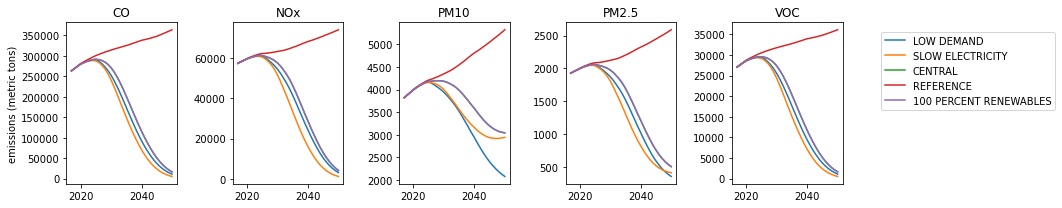

In [37]:
fig, ax_array = plt.subplots(1,len(total_emissions.pollutant.unique()),figsize=(15,3))
np.ravel(ax_array)[0].set_ylabel('emissions (metric tons)')
for i, pol in enumerate(total_emissions.pollutant.unique()):
    pol_inds = total_emissions.pollutant == pol
    ax_array[i].set_title(pol)
    for scenario in scenarios:
        scenario_inds = total_emissions.SCENARIO == scenario
        inds = pol_inds & scenario_inds
        sub_df = total_emissions[inds]
        year = sub_df.YEAR
        em = sub_df['emissions (metric tons)']
        ax_array[i].plot(year, em, label=scenario)
ax_array[i].legend()
np.ravel(ax_array)[i].legend()
np.ravel(ax_array)[i].legend(loc='center left', bbox_to_anchor=(1.3,.7))

plt.tight_layout()
#plt.savefig('my figures/transportation/emissions/{}_total_emissions.png'.format(state_abbrev),dpi=400)        


### Plot criteria air pollutant emissions by vehicle subsector

In [38]:
subsector_emissions = new.groupby(['SCENARIO','SUBSECTOR','pollutant','YEAR'])['emissions (metric tons)'].sum().reset_index()

In [39]:
so2_emissions_byvehicletype = so2_emissions.groupby(['SCENARIO','AIR POLLUTION','SUBSECTOR','YEAR'])['VALUE'].sum().reset_index()
so2_emissions_byvehicletype.rename(columns={'AIR POLLUTION':'pollutant','VALUE':'emissions (metric tons)'},inplace=True)

In [40]:
years = [2040,2050]
so2_emissions_byvehicletype[so2_emissions_byvehicletype['YEAR'].isin(years)]

,SCENARIO,pollutant,SUBSECTOR,YEAR,emissions (metric tons)
23,100 PERCENT RENEWABLES,Sox,heavy duty trucks,2040,13.345664
33,100 PERCENT RENEWABLES,Sox,heavy duty trucks,2050,1.902798
57,100 PERCENT RENEWABLES,Sox,light duty autos,2040,9.647264
67,100 PERCENT RENEWABLES,Sox,light duty autos,2050,1.286219
91,100 PERCENT RENEWABLES,Sox,light duty trucks,2040,32.714780
101,100 PERCENT RENEWABLES,Sox,light duty trucks,2050,4.366473
125,100 PERCENT RENEWABLES,Sox,medium duty trucks,2040,2.078709
135,100 PERCENT RENEWABLES,Sox,medium duty trucks,2050,0.325306
159,100 PERCENT RENEWABLES,Sox,transit buses,2040,0.019355
169,100 PERCENT RENEWABLES,Sox,transit buses,2050,0.000074


In [41]:
subsector_emissions_with_so2 = pd.concat([subsector_emissions, so2_emissions_byvehicletype], ignore_index=True)

In [42]:
subsector_emissions_with_so2

,SCENARIO,SUBSECTOR,pollutant,YEAR,emissions (metric tons)
0,100 PERCENT RENEWABLES,heavy duty trucks,CO,2017,7608.404169
1,100 PERCENT RENEWABLES,heavy duty trucks,CO,2018,7864.063453
2,100 PERCENT RENEWABLES,heavy duty trucks,CO,2019,8081.443272
3,100 PERCENT RENEWABLES,heavy duty trucks,CO,2020,8289.927632
4,100 PERCENT RENEWABLES,heavy duty trucks,CO,2021,8513.743173
...,...,...,...,...,...
6795,SLOW ELECTRICITY,transit buses,Sox,2046,0.001339
6796,SLOW ELECTRICITY,transit buses,Sox,2047,0.000773
6797,SLOW ELECTRICITY,transit buses,Sox,2048,0.000418
6798,SLOW ELECTRICITY,transit buses,Sox,2049,0.000200


In [43]:
subsector_emissions_with_so2.to_csv('my outputs/{}_transportation_totalEmissions_bySubsector_withSOx_{}.csv'.format(state, today_date))

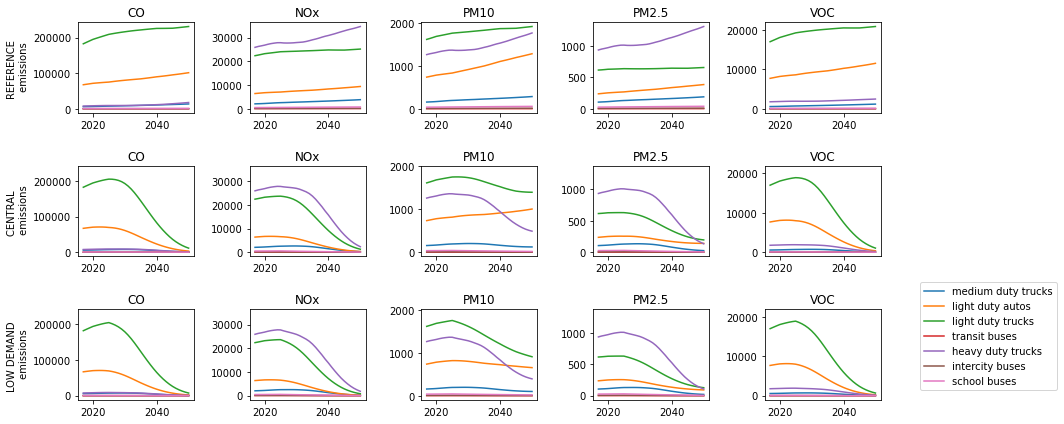

In [44]:
scenarios_select = ["REFERENCE", "CENTRAL", "LOW DEMAND"] #,"100 PERCENT RENEWABLES", "SLOW ELECTRICITY"]
fig, ax_array = plt.subplots(len(scenarios_select),len(subsector_emissions.pollutant.unique()),figsize=(15,6), sharey='col')
for i_scen, scenario in enumerate(scenarios_select):
    scenario_inds = subsector_emissions.SCENARIO == scenario
    ax_array[i_scen, 0].set_ylabel('{} \n emissions'.format(scenario))
    for i, pol in enumerate(subsector_emissions.pollutant.unique()):
        pol_inds = subsector_emissions.pollutant == pol
        ax_array[i_scen, i].set_title(pol)
        for subsector in subsectors:
            subsector_inds = subsector_emissions.SUBSECTOR == subsector
            inds = pol_inds & scenario_inds & subsector_inds
            sub_df = subsector_emissions[inds]
            year = sub_df.YEAR
            em = sub_df['emissions (metric tons)']
            ax_array[i_scen, i].plot(year, em, label=subsector)
ax_array[i_scen, i].legend()
ax_array[i_scen, i].legend(loc='center left', bbox_to_anchor=(1.3,.7))

plt.tight_layout()
#plt.savefig('my figures/transportation/emissions/{}_subsector_emissions.png'.format(state_abbrev),dpi=400)        


## Spatial weighting

### Assign spatial weights to each census tract based on vmt for each vehicle subsector

In [45]:
county_codes = pd.read_excel('../Transportation/county_fipscodes_2017.xlsx', converters={i: str for i in range(0, 7)}, encoding= 'unicode_escape', skiprows=4)
if state == 'colorado':
    state_tract_vmt = pd.read_csv('../Transportation/CO_VMT18/CO_VMT18_fixed.csv')
    vmt_cols = state_tract_vmt.columns[state_tract_vmt.columns.str.contains('vmt')]
elif state == 'new mexico':
    state_tract_vmt = pd.read_csv('../Transportation/VMT_update_Jul2020/NM_VMT18_tract.csv')
    state_tract_vmt['vmt_SUtrucks'] = state_tract_vmt[state_tract_vmt.columns[state_tract_vmt.columns.str.contains('SU_')]].sum(axis=1)
    state_tract_vmt['vmt_CUtrucks'] = state_tract_vmt[state_tract_vmt.columns[state_tract_vmt.columns.str.contains('CT_')]].sum(axis=1)
    state_tract_vmt = state_tract_vmt[['GEOID', 'SUM_VMT_MC_Class1', 'SUM_VMT_PC_Class2', 'SUM_VMT_LT_Class3',
       'SUM_VMT_Bus_Class4', 'vmt_SUtrucks', 'vmt_CUtrucks']]
    state_tract_vmt.rename(columns={'SUM_VMT_MC_Class1':'vmt_Motorcycle','SUM_VMT_PC_Class2':'vmt_PassengerCars','SUM_VMT_LT_Class3':'vmt_LightTrucks',
                               'SUM_VMT_Bus_Class4':'vmt_Buses',},inplace=True)
    vmt_cols = state_tract_vmt.columns[state_tract_vmt.columns.str.contains('vmt')]
elif state == 'nevada':
    state_tract_vmt = pd.read_csv('../Transportation/VMT_update_Jul2020/NV_VMT18_tract.csv')
    vmt_cols = state_tract_vmt.columns[state_tract_vmt.columns.str.contains('VMT')]


In [46]:
tract_weights = state_tract_vmt.groupby(['GEOID'])[vmt_cols].sum().reset_index()
for col in vmt_cols:
    summed = tract_weights[col].sum()
    tract_weights['frac_'+ col] = tract_weights[col] / summed
tract_weights.drop(columns=vmt_cols,inplace=True)
tract_weights.columns = tract_weights.columns.str.replace('frac_VMT_', '')
tract_weights.columns = tract_weights.columns.str.replace('frac_vmt_', '')
tract_weights.columns = tract_weights.columns.str.replace('frac_SUM_VMT_', '')

In [47]:
county_codes = county_codes[county_codes['State Code (FIPS)']==state_fips]
county0_inds = county_codes['County Code (FIPS)']=='000'
county_codes = county_codes[~county0_inds]
county_codes = county_codes[['County Code (FIPS)','Area Name (including legal/statistical area description)']]
county_codes.rename(columns={'County Code (FIPS)':'County Code',
                             'Area Name (including legal/statistical area description)': 'County Name'},inplace=True)



In [48]:
for code in county_codes['County Code'].unique():
    if state == 'colorado':
        county_inds = tract_weights['GEOID'].astype(str).str[1:4]==code
    else:
        county_inds = tract_weights['GEOID'].astype(str).str[2:5]==code
    countycode_inds = county_codes['County Code']==code
    county = county_codes[countycode_inds]['County Name'].item()
    tract_weights.loc[county_inds,'County']= county

In [49]:
subsector_emissions = new.groupby(['SCENARIO','SUBSECTOR','YEAR','pollutant'])['emissions (metric tons)'].sum().reset_index()

In [50]:
ghg_emissions = pd.read_csv('combined_outputs/c_emissions.csv', low_memory = False)
ghg_emissions = ghg_emissions[ghg_emissions['SECTOR']=='transportation']
ghg_emissions = ghg_emissions[ghg_emissions['WESTERN STATES-CONSUMED']==state]
subsector_inds = ghg_emissions['SUBSECTOR'].isin(subsectors)
bus_inds = ghg_emissions['SUBSECTOR']=='school and intercity buses'
ghg_emissions = ghg_emissions[subsector_inds | bus_inds]
ghg_emissions = ghg_emissions[ghg_emissions['SUPPLY/DEMAND']=='DEMAND']
ghg_emissions_bysubsector = ghg_emissions.groupby(['SCENARIO', 
                                'GHG', 'SUBSECTOR', 'YEAR'])['TONNE'].sum().reset_index()
ghg_emissions_bysubsector.rename(columns={'GHG':'pollutant','TONNE':'emissions (metric tons)'}, inplace=True)
subsector_emissions = pd.concat([subsector_emissions,ghg_emissions_bysubsector])

In [51]:
r = np.arange(len(subsector_emissions)).repeat(len(tract_weights))
weights_df = pd.concat([tract_weights]*len(subsector_emissions),ignore_index=True)
tract_emissions_bysubsector = pd.DataFrame(subsector_emissions.values[r], columns = subsector_emissions.columns).join(weights_df)

In [52]:
mapping = {
        'light duty autos': 'PassengerCars',
        'light duty trucks':'LightTrucks',
        'school buses':'Buses', 
        'transit buses':'Buses',
        'intercity buses': 'Buses',
        'school and intercity buses':'Buses',
        'medium duty trucks': 'SUtrucks',
        'heavy duty trucks': 'CUtrucks'   
    }

In [53]:
for subsector in tract_emissions_bysubsector['SUBSECTOR'].unique():
    subsector_inds = tract_emissions_bysubsector['SUBSECTOR']==subsector
    weight_col = mapping[subsector] 
    tract_emissions_bysubsector.loc[subsector_inds,'emissions (metric tons)'] = tract_emissions_bysubsector.loc[subsector_inds,'emissions (metric tons)'] * tract_emissions_bysubsector.loc[subsector_inds, weight_col]

#### Reformat tract-level emissions dataset for cross-sector analysis

In [54]:
tract_emissions_bysubsector.drop(columns = ['Motorcycle',
       'PassengerCars', 'LightTrucks', 'Buses', 'SUtrucks', 'CUtrucks'], inplace=True)
if state == 'colorado':
    tract_emissions_bysubsector.drop(columns ='Total',inplace=True)

In [55]:
tract_emissions_bysubsector.insert(loc=0, column='State',value= state_abbrev)
tract_emissions_bysubsector.columns = [x.title() for x in tract_emissions_bysubsector.columns]
tract_emissions_bysubsector.insert(loc=1, column='Sector',value='Transportation')
tract_emissions_bysubsector.rename(columns={'Subsector': 'Source Type','Pollutant': 'Pollutant Type', 'Emissions (Metric Tons)':'Emissions (tonnes / year)',
                               'Geoid': 'Census Tract'}, inplace=True)
tract_emissions_bysubsector.insert(loc=5, column='Data Category',value='NP')
tract_emissions_bysubsector.insert(loc=3, column='Pollutant Category', value='CAP')
tract_emissions_bysubsector.insert(loc=4, column='Data source', value='Evolved')
tract_emissions_bysubsector.loc[tract_emissions_bysubsector['Pollutant Type']=='VOC','Pollutant Category']='CAP (precursor)'
tract_emissions_bysubsector.loc[tract_emissions_bysubsector['Pollutant Type']=='CO2','Pollutant Category']='GHG'
tract_emissions_bysubsector = tract_emissions_bysubsector[['Year','State', 'County', 
                                    'Census Tract','Sector', 'Source Type',
       'Data Category', 'Scenario', 'Pollutant Category', 'Pollutant Type',
       'Emissions (tonnes / year)', 'Data source']]

In [56]:
tract_emissions_bysubsector.to_csv('my outputs/{}_transportation_tractEmissions_bySubsector_CAPsCO2_{}.csv'.format(state,today_date))

### Calculate statewide emissions (NOx, PM2.5) for year 2017 by fuel type.

In [57]:
fuel_emissions = new.groupby(['SCENARIO','YEAR','Fuel Type','pollutant'])['emissions (metric tons)'].sum().reset_index()
fuel_emissions_baseline = fuel_emissions[fuel_emissions['YEAR']==2017]
fuel_emissions_ref_baseline = fuel_emissions_baseline[fuel_emissions_baseline['SCENARIO']=='REFERENCE']
pm25_inds = fuel_emissions_ref_baseline['pollutant'] == 'PM2.5'
nox_inds = fuel_emissions_ref_baseline['pollutant'] == 'NOx'
                                        
fuel_emissions_ref_baseline = fuel_emissions_ref_baseline[pm25_inds | nox_inds]
fuel_emissions_ref_baseline.replace({'FCV':'Hydrogen', 'EV':'Electricity', 'diesel':'Oil','gasoline':'Oil','CNG':'Natural Gas', 
                                     'E85':'Oil','LNG':'Natural Gas','LPG':'Oil'}, inplace=True)
fuel_emissions_ref_baseline = fuel_emissions_ref_baseline[fuel_emissions_ref_baseline['Fuel Type'] != 'HEV']
fuel_emissions_ref_baseline = fuel_emissions_ref_baseline[fuel_emissions_ref_baseline['Fuel Type'] != 'PHEV']

In [58]:
fuel_emissions_ref_baseline = fuel_emissions_ref_baseline.groupby(['SCENARIO','YEAR','Fuel Type','pollutant'])['emissions (metric tons)'].sum().reset_index()

### Get CO2 emissions by fuel type for year 2017 from Evolved outputs.

In [59]:
# electricity_inds = ghg_emissions_bysubsector['FINAL_ENERGY']=='electricity'
# hydrogen_inds = ghg_emissions_bysubsector['FINAL_ENERGY']=='liquid hydrogen'
# instate_inds = ghg_emissions_bysubsector['WESTERN STATES-EMITTED'] == state
# electricity_instate = electricity_inds & instate_inds
# hydrogen_instate = hydrogen_inds & instate_inds
# ghg_emissions_bysubsector = ghg_emissions_bysubsector[~electricity_instate]
# ghg_emissions_bysubsector = ghg_emissions_bysubsector[~hydrogen_instate]

In [60]:
fuel_emissions_ref_baseline.rename(columns={'SCENARIO':'Scenario','YEAR':'Year',
    'pollutant':'Pollutant','emissions (metric tons)':'Annual Emissions (metric tons)'},inplace=True)

In [61]:
ghg_emissions_byfuel = ghg_emissions[ghg_emissions['YEAR']==2017]
ghg_emissions_byfuel = ghg_emissions_byfuel[ghg_emissions_byfuel['SCENARIO']=='REFERENCE']
ghg_emissions_byfuel = ghg_emissions_byfuel.groupby(['SCENARIO','YEAR','FINAL_ENERGY','GHG',])['TONNE'].sum().reset_index()
ghg_emissions_byfuel.replace({'diesel fuel':'Oil','gasoline fuel':'Oil', 
                            'lpg fuel':'Oil'}, inplace=True)
                          #'liquid hydrogen':'Hydrogen', 'electricity':'Electricity'
ghg_emissions_byfuel = ghg_emissions_byfuel.groupby(['SCENARIO','YEAR','FINAL_ENERGY','GHG'])['TONNE'].sum().reset_index()
ghg_emissions_byfuel.columns = ghg_emissions_byfuel.columns.str.title()
ghg_emissions_byfuel.rename(columns={'Final_Energy':'Fuel Type','Ghg':'Pollutant','Tonne': 'Annual Emissions (metric tons)'},inplace=True)
ghg_emissions_byfuel.replace({'transportation':'Transportation'},inplace=True)

emissions_byfuel = pd.concat([fuel_emissions_ref_baseline, ghg_emissions_byfuel],ignore_index=True)


### Input CO2 emissions from EIA fo 2017 natural gas and oil usage.

In [62]:
if state == 'colorado':
    gas_co2 = 400000
    oil_co2 = 28100000
elif state == 'nevada':
    gas_co2 = 300000
    oil_co2 = 15100000
elif state == 'new mexico':
    gas_co2 = 500000
    oil_co2 = 14500000


row_additions = pd.DataFrame([['REFERENCE',2017,'Electricity','CO2',0], 
                             ['REFERENCE',2017,'Hydrogen','CO2',0],['EIA',2017,'Natural Gas','CO2',gas_co2],
                             ['EIA',2017,'Oil','CO2',oil_co2]], 
                            columns=['Scenario','Year','Fuel Type', 'Pollutant',
                                        'Annual Emissions (metric tons)'])
emissions_byfuel = pd.concat([emissions_byfuel,row_additions],ignore_index=True)
emissions_byfuel.rename(columns={'Annual Emissions (metric tons)':'End-use emissions (tonnes / year)'},inplace=True)
emissions_byfuel.replace({'Transporation':'Transportation'},inplace=True)

#### Save file with statewide CO2, NOx, and PM2.5 emissions by fuel type for year 2017.

In [63]:
emissions_byfuel['Sector']='Transportation'
emissions_byfuel['Year']='2017'
emissions_byfuel['State'] = state
emissions_byfuel.columns = emissions_byfuel.columns.str.title()
allemissions_byfuel = pd.concat([emissions_byfuel, so2_emissions_ref_baseline],ignore_index=True)
allemissions_byfuel = allemissions_byfuel.replace('Sox','SOx')

In [64]:
allemissions_byfuel

,Scenario,Year,Fuel Type,Pollutant,End-Use Emissions (Tonnes / Year),Sector,State
0,REFERENCE,2017,Electricity,NOx,0.000000e+00,Transportation,colorado
1,REFERENCE,2017,Electricity,PM2.5,7.495661e-02,Transportation,colorado
2,REFERENCE,2017,Hydrogen,NOx,0.000000e+00,Transportation,colorado
3,REFERENCE,2017,Hydrogen,PM2.5,3.072597e-03,Transportation,colorado
4,REFERENCE,2017,Natural Gas,NOx,2.090399e+01,Transportation,colorado
5,REFERENCE,2017,Natural Gas,PM2.5,5.064008e+00,Transportation,colorado
6,REFERENCE,2017,Oil,NOx,5.719217e+04,Transportation,colorado
7,REFERENCE,2017,Oil,PM2.5,1.913058e+03,Transportation,colorado
8,REFERENCE,2017,Electricity,CO2,0.000000e+00,Transportation,colorado
9,REFERENCE,2017,Hydrogen,CO2,0.000000e+00,Transportation,colorado


In [65]:
allemissions_byfuel.to_csv('my outputs/{}_transportation_statewideEmissions_byFuel_CO2noxPM25sox_{}.csv'.format(state, today_date))